### Installing necessary libraries

In [ ]:
!pip -qq install transformers
!pip -qq install datasets

In [2]:
import pandas as pd
import transformers
import datasets
import nltk
import numpy as np
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
import torch.nn as nn
import random
import os

from transformers import GPT2Tokenizer
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2LMHeadModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import Trainer
from transformers import TrainingArguments

### Importing and Preprocessing Data

In [22]:
filename = "/kaggle/input/elon-musk-tweets-2010-2021/2020.csv"
df = pd.read_csv(filename)  
print(df.columns)

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'date', 'timezone',
       'place', 'tweet', 'language', 'hashtags', 'cashtags', 'user_id',
       'user_id_str', 'username', 'name', 'day', 'hour', 'link', 'urls',
       'photos', 'video', 'thumbnail', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest'],
      dtype='object')


In [5]:
df = df[['tweet']].astype(str)
df.dropna(inplace=True)

In [6]:
df.head()

,tweet
0,Entertainment will be critical when cars drive...
1,@kimpaquette Just meeting with Larry Ellison t...
2,@richierichhhhh_ Absolutely
3,What should Tesla do with in-car gaming in an ...
4,@PPathole @WSJ Absolutely


In [7]:
df.shape

(11717, 1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


17.73431765810361


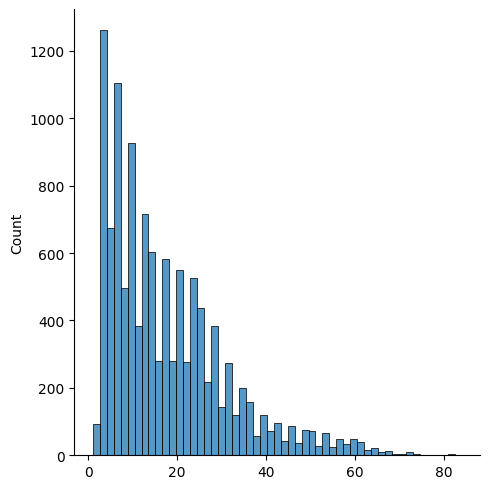

In [8]:
doc_lengths = []
for elem in df['tweet']:
    # get rough token count distribution
    tokens = nltk.word_tokenize(elem)
    doc_lengths.append(len(tokens))
doc_lengths = np.array(doc_lengths)
sns.displot(doc_lengths)
print(np.average(doc_lengths))

### Modifying data using GPT2 tokenizer into suitable format.

In [9]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>') #

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [10]:
training_examples = f'<|startoftext|> ' + df['tweet'] + '<|endoftext|>'
print(training_examples[0])

<|startoftext|> Entertainment will be critical when cars drive themselves<|endoftext|>


In [11]:
task_df = pd.DataFrame({'text': training_examples})
task_df.head()

,text
0,<|startoftext|> Entertainment will be critical...
1,<|startoftext|> @kimpaquette Just meeting with...
2,<|startoftext|> @richierichhhhh_ Absolutely<|e...
3,<|startoftext|> What should Tesla do with in-c...
4,<|startoftext|> @PPathole @WSJ Absolutely<|end...


### Using HF Dataset and DataCollator

In [12]:
from datasets import Dataset
tweet_data = Dataset.from_pandas(task_df)  # turn a pandas DataFrame into a Dataset

def preprocess(example):  # tokenize our text but don't pad because our collator will pad for us dynamically
    return tokenizer( example['text'], truncation=True)

tweet_data = tweet_data.map(preprocess, batched=False)
tweet_data = tweet_data.train_test_split(train_size=.8)

  0%|          | 0/11717 [00:00<?, ?ex/s]

In [13]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

### Downloading and Testing gpt2 Model without Fine-Tuning

In [14]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50259, 768)

In [15]:
# device = torch.device("cuda")
# model.to(device)
model.eval()
prompt = "<|startoftext|> I wonder"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
# generated = generated.to(device)
print(generated)
sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=20, 
                                max_length = 300,
                                top_p=0.98, 
                                num_return_sequences=10,
                                )
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}nn".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,   314,  4240]])
0:  I wonder Pantsnn
1:  I wondernn
2:  I wonder Dudleynn
3:  I wondernn
4:  I wondernn
5:  I wonder defectsethynn
6:  I wonderariumnn
7:  I wondernn
8:  I wondernn
9:  I wonder Jesusnn


### Configuring HF trainer, Optimizers and Model Training

In [17]:
epochs = 2
learning_rate = 2e-4
warmup_steps = 1e2
epsilon = 1e-8

optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon,
                  no_deprecation_warning=True
                )


total_steps = len(tweet_data["train"]) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps,
                                            )

In [18]:
seed_val = 38

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
batch_size = 8
     
training_args = TrainingArguments(
    output_dir="./tweets",
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs= epochs, # number of training epochs
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    load_best_model_at_end=True,
    logging_steps=5,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate= learning_rate,
    warmup_steps=warmup_steps,
    seed= 38,
    
     
     
 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tweet_data["train"],
    eval_dataset=tweet_data["test"],
    data_collator=data_collator,
    optimizers = (optimizer, scheduler),
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [28]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9,373
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Training with DataParallel so batch size has been adjusted to: 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1,172
  Number of trainable parameters = 124,441,344
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,3.830400,3.783880
2,3.399100,3.737322


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2344
  Batch size = 16
Saving model checkpoint to ./tweets/tmp-checkpoint-586
Configuration saved in ./tweets/tmp-checkpoint-586/config.json
Configuration saved in ./tweets/tmp-checkpoint-586/generation_config.json
Model weights saved in ./tweets/tmp-checkpoint-586/pytorch_model.bin
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected b

TrainOutput(global_step=1172, training_loss=3.949824777072607, metrics={'train_runtime': 442.752, 'train_samples_per_second': 42.34, 'train_steps_per_second': 2.647, 'total_flos': 620751276288000.0, 'train_loss': 3.949824777072607, 'epoch': 2.0})

In [29]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2344
  Batch size = 16
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.7373220920562744,
 'eval_runtime': 16.8301,
 'eval_samples_per_second': 139.274,
 'eval_steps_per_second': 8.734,
 'epoch': 2.0}

### Evaluating Model by generating text.

In [36]:
model.eval()

prompt = "<|startoftext|> I wonder"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to('cuda')

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=20, 
                                max_length = 70,
                                top_p=0.98, 
                                num_return_sequences=10,
                                temperature=0.95

                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,   314,  4240]], device='cuda:0')
0:  I wonder what happens to the astronauts if they are not taken over the moon? Would be interesting to see them here for a year or so.


1:  I wonder if anyone noticed. Maybe it will be the people of Tesla.


2:  I wonder what the hell happened to those who attacked me  http://t.co/wFhHn0WwY


3:  I wonder what the future looks like when Tesla cars have superalloys.


4:  I wonder what we will do to stop it


5:  I wonder what it’s going to take


6:  I wonder what the future may look like for humanity. It is not far from certain.  https://t.co/w9nLQnJpM


7:  I wonder what the future looks like


8:  I wonder what's going through my mind when I look at a small sphere of ice on the side of the moon


9:  I wonder if it’s worth a shot  https://t.co/Lg8fHn6rQ




It seems pretty goods, results, realist, we see that the model add the hashtags and even fake links.